# Stacking

$Stacking$的基本思想是：首先使用原始的训练数据来训练一级学习器；之后，用一级学习器的输出作为输入特征，并使用对应原始标记作为新标记，组成一个新数据来训练二级学习器。一级学习器常用不同的学习算法，因此$Stacking$学习器通常是异质的。

```
同质（Homogeneity ）与异质（Heterogeneity）系一对科学与统计学中常用的对一种生物组织或物质的均匀性进行描述的概念。如果一种材料或一幅图像具有同质性（或者说是同质的），那么它就是由同样的单元堆砌而成的，或者它各部分的特征（如颜色、形状、大小、重量、高度、分布、质地、语言、收入、疾病、温度、放射性、架构设计等）都是相同的。相对的，如果一种物质至少一种特征的分布明显不均匀，那么它就具有异质性。
```

一方面，$Stacking$是一种通用框架，可以看成是多种集成方法的泛化；另一方面，他也可以看成是一种通过学习进行结合的特殊学习方法。通用的$Stacking$伪代码如下图所示：

![](Stacking.png)

在$Stacking$的训练阶段，一级分类器需要生成一个新的数据集。如果使用训练一级学习器的真实数据来生成新数据集，并用于训练二级学习器，就会有很高的过拟合风险，因此，一般是通过使用交叉验证或留一法这种方式，用训练一级学习器未使用的样本来产生二级学习器的训练样本。在Blending中，我们产生验证集的方式是使用分割的方式，产生一组训练集和一组验证集，对于刚刚讨论的利用交叉验证的方法，我们对Stacking进行建模(如下图)：  

                       
![jupyter](./4.jpg)                                               

   - 首先将所有数据集生成测试集和训练集（假如训练集为10000,测试集为2500行），那么上层会进行5折交叉检验，使用训练集中的8000条作为训练集，剩余2000行作为验证集（橙色）。                                         
   - 每次验证相当于使用了蓝色的8000条数据训练出一个模型，使用模型对验证集进行验证得到2000条数据，并对测试集进行预测，得到2500条数据，这样经过5次交叉检验，可以得到中间的橙色的5* 2000条验证集的结果(相当于每条数据的预测结果)，5* 2500条测试集的预测结果。                                           
   - 接下来会将验证集的5* 2000条预测结果拼接成10000行长的矩阵，标记为$A_1$，而对于5* 2500行的测试集的预测结果进行加权平均，得到一个2500一列的矩阵，标记为$B_1$。                            
   - 上面得到一个基模型在数据集上的预测结果$A_1$、$B_1$,这样当我们对3个基模型进行集成的话，相于得到了$A_1$、$A_2$、$A_3$、$B_1$、$B_2$、$B_3$六个矩阵。                            
   - 之后我们会将$A_1$、$A_2$、$A_3$并列在一起成10000行3列的矩阵作为training data,$B_1$、$B_2$、$B_3$合并在一起成2500行3列的矩阵作为testing  data，让下层学习器基于这样的数据进行再训练。              
   - 再训练是基于每个基础模型的预测结果作为特征（三个特征），次学习器会学习训练如果往这样的基学习的预测结果上赋予权重w，来使得最后的预测最为准确。

下面，我们来实际应用下Stacking是如何集成算法的：(参考案例：https://www.cnblogs.com/Christina-Notebook/p/10063146.html)                                                          
![jupyter](./5.png)                                  
**由于sklearn并没有直接对Stacking的方法，因此我们需要下载mlxtend工具包(pip install mlxtend)**

In [7]:
# 1. 简单堆叠3折CV分类
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier

RANDOM_SEED = 42

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],  # 第一层分类器
                            meta_classifier=lr,   # 第二层分类器
                            random_state=RANDOM_SEED)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], ['KNN', 'Random Forest', 'Naive Bayes','StackingClassifier']):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.93 (+/- 0.02) [StackingClassifier]


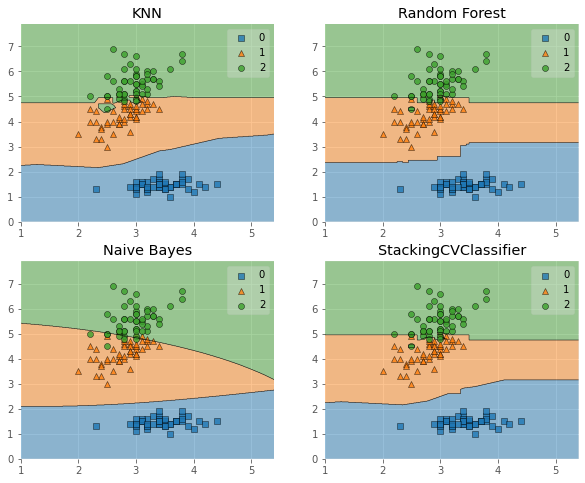

In [8]:
# 我们画出决策边界
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10,8))
for clf, lab, grd in zip([clf1, clf2, clf3, sclf], 
                         ['KNN', 
                          'Random Forest', 
                          'Naive Bayes',
                          'StackingCVClassifier'],
                          itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(lab)
plt.show()


使用第一层所有基分类器所产生的类别概率值作为meta-classfier的输入。需要在StackingClassifier 中增加一个参数设置：use_probas = True。

另外，还有一个参数设置average_probas = True,那么这些基分类器所产出的概率值将按照列被平均，否则会拼接。

例如：

基分类器1：predictions=[0.2,0.2,0.7]

基分类器2：predictions=[0.4,0.3,0.8]

基分类器3：predictions=[0.1,0.4,0.6]

1）若use_probas = True，average_probas = True，

    则产生的meta-feature 为：[0.233, 0.3, 0.7]

2）若use_probas = True，average_probas = False，

    则产生的meta-feature 为：[0.2,0.2,0.7,0.4,0.3,0.8,0.1,0.4,0.6]

In [9]:
# 2.使用概率作为元特征
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            use_probas=True,  # 
                            meta_classifier=lr,
                            random_state=42)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'Naive Bayes',
                       'StackingClassifier']):

    scores = cross_val_score(clf, X, y, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.91 (+/- 0.01) [KNN]
Accuracy: 0.95 (+/- 0.01) [Random Forest]
Accuracy: 0.91 (+/- 0.02) [Naive Bayes]
Accuracy: 0.95 (+/- 0.02) [StackingClassifier]


In [10]:
# 3. 堆叠5折CV分类与网格搜索(结合网格搜索调参优化)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.classifier import StackingCVClassifier

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], 
                            meta_classifier=lr,
                            random_state=42)

params = {'kneighborsclassifier__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.947 +/- 0.03 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.933 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.940 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier__n_neighbors': 5, 'meta_classifier__C': 10.0, 'randomforestclassifier_

In [11]:
# 如果我们打算多次使用回归算法，我们要做的就是在参数网格中添加一个附加的数字后缀，如下所示：
from sklearn.model_selection import GridSearchCV

# Initializing models

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf1, clf2, clf3], 
                            meta_classifier=lr,
                            random_state=RANDOM_SEED)

params = {'kneighborsclassifier-1__n_neighbors': [1, 5],
          'kneighborsclassifier-2__n_neighbors': [1, 5],
          'randomforestclassifier__n_estimators': [10, 50],
          'meta_classifier__C': [0.1, 10.0]}

grid = GridSearchCV(estimator=sclf, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 50}
0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 10}
0.940 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 1, 'meta_classifier__C': 10.0, 'randomforestclassifier__n_estimators': 50}
0.960 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestclassifier__n_estimators': 10}
0.953 +/- 0.02 {'kneighborsclassifier-1__n_neighbors': 1, 'kneighborsclassifier-2__n_neighbors': 5, 'meta_classifier__C': 0.1, 'randomforestcla

In [12]:
# 4.在不同特征子集上运行的分类器的堆叠
##不同的1级分类器可以适合训练数据集中的不同特征子集。以下示例说明了如何使用scikit-learn管道和ColumnSelector：
from sklearn.datasets import load_iris
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

iris = load_iris()
X = iris.data
y = iris.target

pipe1 = make_pipeline(ColumnSelector(cols=(0, 2)),  # 选择第0,2列
                      LogisticRegression())
pipe2 = make_pipeline(ColumnSelector(cols=(1, 2, 3)),  # 选择第1,2,3列
                      LogisticRegression())

sclf = StackingCVClassifier(classifiers=[pipe1, pipe2], 
                            meta_classifier=LogisticRegression(),
                            random_state=42)

sclf.fit(X, y)

StackingCVClassifier(classifiers=[Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=(0, 2))),
                                                  ('logisticregression',
                                                   LogisticRegression())]),
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=(1, 2,
                                                                        3))),
                                                  ('logisticregression',
                                                   LogisticRegression())])],
                     meta_classifier=LogisticRegression(), random_state=42)

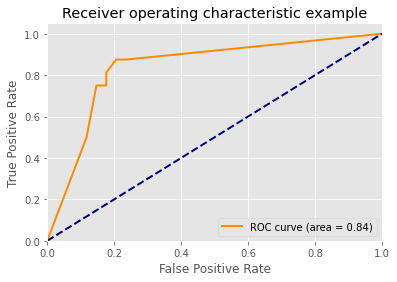

In [13]:
# 5.ROC曲线 decision_function
### 像其他scikit-learn分类器一样，它StackingCVClassifier具有decision_function可用于绘制ROC曲线的方法。
### 请注意，decision_function期望并要求元分类器实现decision_function。
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

iris = datasets.load_iris()
X, y = iris.data[:, [0, 1]], iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_SEED)

clf1 =  LogisticRegression()
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = SVC(random_state=RANDOM_SEED)
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(sclf)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**Blending与Stacking对比：**                               
Blending的优点在于：
   - 比stacking简单（因为不用进行k次的交叉验证来获得stacker feature）

而缺点在于：
   - 使用了很少的数据（是划分hold-out作为测试集，并非cv）
   - blender可能会过拟合（其实大概率是第一点导致的）
   - stacking使用多次的CV会比较稳健